# <div align="center">MNIST: Handwritten Digit Classification<div>

 <div align="center"> Here we shall use a simple 3-layered <i>Multilayer Perceptron</i> to classify <b>MNIST</b> <i>Handwritten Dataset</i>.The dataset consists of 60,000 small square 28×28 pixel grayscale training images of handwritten single digits between 0 and 9 and 10,000 testing samples. A general architecture of the model to be used is shown below in the image.</div> 

![Model](./Model.jpg)

In [1]:
import numpy as np
import pandas as pd
import scipy.special
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

#Here the 1st column represents the labesl
DataBase = pd.read_csv('./Data/train_60000.csv')
Test_Data = pd.read_csv('./Data/test_10000.csv')

#Seperating the Label from the Features
Data = DataBase.iloc[:,1:]
Labels = DataBase.iloc[:,0].values

#Seperating the Label from the Features for Test data
TData = Test_Data.iloc[:,1:]
TLabels = Test_Data.iloc[:,0].values

#Adding the Bias term to Data
Data.insert(0,"Bias",1)
TData.insert(0,"Bias",1)

#### Visualizing the data

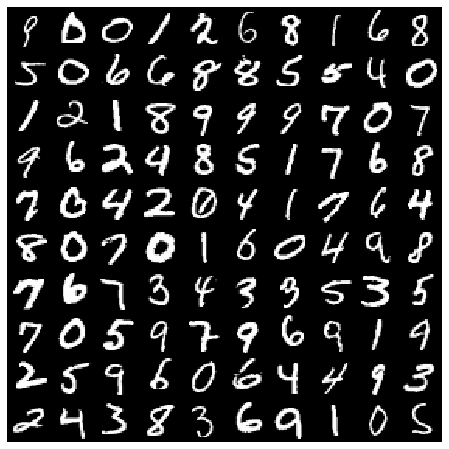

In [2]:
Index = random.sample(range(Data.shape[0]),100)

def Convert_28x28(x):
    """
    Function that is handed a single np array with shape 1x400,
    crates a 20x20 image object from it, and returns it
    """
    width,height = 28,28 #The dimensions of the image
    x = x.values
    img = x.reshape(width,height)
    return img
def Display_Grid(indices_to_display):
    """
    Function that picks 100 random rows from X, creates a 28x28 pixel image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    
    width,height = 28,28 #The dimensions of the image
    nrows,ncols = 10,10 #The dimensions of the Image grid
    Grid = np.zeros((nrows*28,ncols*28)) #Each image is 20x20 therefor the Grid dimension is 200x200
    
    
    irow,icol = 0,0 #Index of the images in the Grid
    for index in indices_to_display:
        if(icol==ncols): #Here we are filling the Grid with images row wise 
            irow +=1
            icol  =0
        img = Convert_28x28(Data.iloc[index,1:]) #0th column is bias
        Grid[irow*height:irow*height+28,icol*width:icol*width+28] = img
        icol +=1
    
    fig = plt.figure(figsize=(20,8))
    plt.imshow(Grid,cmap = cm.Greys_r)
    plt.axis('off')
    
    
Display_Grid(Index)

#### Dividing the Data into Training and Cross-Validation set

In [3]:
#Training Data
Train_Data = Data.iloc[0:42000,:]
Train_Labels = Labels[0:42000]

#Cross alidation Data
CrossVal_Data = Data.iloc[41999:,:].values
CrossVal_Labels = Labels[41999:]

#No of Training Samples
m1 = Train_Data.shape[0]
#No of Cross-Validation samples
m2 = CrossVal_Data.shape[0]
#No of Testing samples
m3 = Test_Data.shape[0]

print("No of Training Samples",m1)
print("No of Cross-Validation samples",m2)
print("No of Testing samples",m3)

No of Training Samples 42000
No of Cross-Validation samples 18000
No of Testing samples 9999


#### Normalizing the Data

In [4]:
#Mean Normalization
def M_Normalize(dataset):
    
    dataset = dataset.T 
    Norm_D = (dataset.iloc[1:,:]-dataset.iloc[1:,:].mean())/(dataset.iloc[1:,:].std())
    Norm_D = Norm_D.T
    Norm_D.insert(0,"Bias",1)
    return Norm_D

Train_Data = M_Normalize(Train_Data)
Train_Data = Train_Data.values

#### Parameters

In [5]:
#No of Features
nInputNodes = Data.shape[1]
#No of HiddenNodes in Layer_1
nHiddenNodes = 100
#No of Output Nodes
nOutPutNodes = len(np.unique(Labels, return_counts=False))
#Learning Rate
lr = 0.38
#No of Iterartions
epochs = 12

#### Model

In [6]:
class FF_Net:
    
    #parameters of the NeuralNetwork,self is the instance reference
    def __init__(self,inputNodes,hiddenNodes,outputNodes,learningRate,e):
        
        np.random.seed(200)
        self.nInputNodes = inputNodes
        self.nHiddenNodes = hiddenNodes
        self.nOutPutNodes = outputNodes
        self.lr = learningRate
        self.epoch = e
        #Initializing the weights from Input to Hidden Layer
        
        #The Matrices are wih and who.
        
        #Weights between Input Layer and Hidden Layer
        self.Wih = np.random.normal(0.0,pow(nInputNodes,-0.5),(self.nHiddenNodes,self.nInputNodes)) 
        #Weights between Hidden Layer and Output Layer
        self.Who = np.random.normal(0.0,pow(nInputNodes,-0.5),(self.nOutPutNodes,self.nHiddenNodes)) 
        
        #Implimenting the Sigmoid Function
        self.activation_function=lambda x:scipy.special.expit(x)
        
        self.EHist = []
        self.Validation_Error = []
        
        pass
    
    def Train(self,Inputs,Targets):
        
        #calculate the summation of signals into hidden layer
        hidden_inputs = np.dot(self.Wih,Inputs)
        #calculaing the hidden output
        hidden_outputs = self.activation_function(hidden_inputs).reshape(self.nHiddenNodes,1)

        #calculate the summation of signals into output layer
        final_inputs = np.dot(self.Who, hidden_outputs)
        #calculaing the Final Output
        final_outputs = self.activation_function(final_inputs)

        # output layer error is the (target - actual)
        output_errors = Targets - final_outputs
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.Who.T, output_errors)
    
        # update the weights for the links between the hidden and output layers
        self.Who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))    
        # update the weights for the links between the input and hidden layers
        self.Wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(Inputs)) 
        
        return np.sum(np.square(output_errors))
    
    def Validation(self,Inputs,Targets):

        hidden_inputs = np.dot(self.Wih,Inputs)
        hidden_outputs = self.activation_function(hidden_inputs).reshape(self.nHiddenNodes,1)
        final_inputs = np.dot(self.Who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        output_errors = Targets - final_outputs
        
        return np.sum(np.square(output_errors))
    
    def run_Train(self,Data_Train, Data_Validation):
       
        for e in range(self.epoch):
            Error=0
            # go through all records in the training data set
            for i,record in enumerate(Data_Train):
                targets = np.zeros(nOutPutNodes).reshape(-1,1)
                targets[Train_Labels[i]]=1
                Error += self.Train(record.reshape(-1,1),targets)
            Error/=len(Data_Train)
            self.EHist.append(Error)
            VError=0
            for j,record in enumerate(Data_Validation):
                targets = np.zeros(nOutPutNodes).reshape(-1,1)
                targets[CrossVal_Labels[j]]=1
                VError += self.Validation(record.reshape(-1,1),targets)
            VError/=len(Data_Validation)
            self.Validation_Error.append(VError)
            pass
        
    def Predict(self,inputs):
        
        hidden_inputs = np.dot(self.Wih,inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.Who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs
    
    def Plot(self):
        
        plt.figure(figsize=(5,5))
        plt.plot(self.EHist,label='Training Error')
        plt.plot(self.Validation_Error,label ='Validation error')
        plt.legend(loc='upper right')
        plt.title("Training Vs Validation Error [HiddenNodes{}]".format(self.nHiddenNodes))
        plt.xlabel("Number of Iterations: {}".format(self.epoch))
        plt.ylabel("Error")
        plt.show()
       
    pass

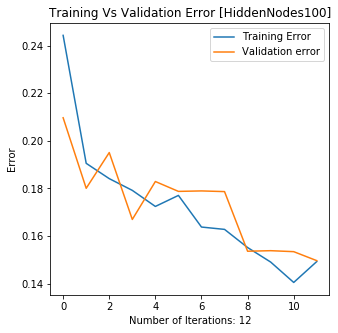

In [7]:
Model1 = FF_Net(nInputNodes,nHiddenNodes,nOutPutNodes,lr,epochs)
Model1.run_Train(Train_Data,CrossVal_Data)
Model1.Plot()

In [8]:
scorecard = []
for i,record in enumerate(TData.values):
    output = Model1.Predict(record.reshape(-1,1))
    if(TLabels[i] == np.argmax(output)):
        scorecard.append(1)
    else:
        scorecard.append(0)
        
scorecard_array = np.asarray(scorecard)
print ("performance = ", (scorecard_array.sum() / scorecard_array.size)*100,"% Accurate")

performance =  91.98919891989199 % Accurate


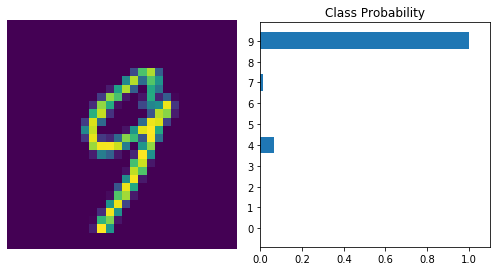

In [62]:
''' 
Function for viewing an image and it's predicted classes.
'''
idx = random.sample(range(TData.shape[0]),1)
Out_p = Model1.Predict(TData.iloc[idx,:].values.reshape(-1,1))

def View_classify(img,p):
    
    fig, (ax1, ax2) = plt.subplots(figsize=(7,9), ncols=2)
    ax1.imshow(img.reshape(1, 28, 28).squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), p.squeeze())
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    
View_classify(TData.iloc[idx,1:].values,Out_p)